In [1]:
import cv2
import os
import re
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from tqdm import tqdm

In [2]:
import torch
import onnx
import onnxruntime as ort
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(device)

cpu


In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# from torchvision.datasets import VOCDetection
# #downLoad Pascal VOC dataset
# VOCDetection(root='VOC_data', year='2012', image_set='trainval', download=True)

In [5]:
VOC_CLASSES_original = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

In [6]:
# Define VOC_CLASSES for segmentation
VOC_CLASSES = {
    "bicycle": 2, "bus": 6, "car": 7, "motorbike": 14, "person": 15
}
# Re-index values
VOC_CLASSES_ReIndex = {name: idx+1 for idx, (name, _) in enumerate(VOC_CLASSES.items())}
print(VOC_CLASSES_ReIndex)

{'bicycle': 1, 'bus': 2, 'car': 3, 'motorbike': 4, 'person': 5}


In [7]:
class Config:
    learning_rate = 0.005
    momentum = 0.9
    weight_decay = 0.0005
    patience = 3
    classes = VOC_CLASSES_ReIndex

In [8]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN model with ResNet50 backbone
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        progress=True,
        weights_backbone=ResNet50_Weights.DEFAULT,
        trainable_backbone_layers=5
    )

    # Custom anchor generation
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))  # Custom sizes for each feature map level # check image size
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes) # Same aspect ratios for all levels
    anchor_generator = AnchorGenerator(
        sizes=anchor_sizes,
        aspect_ratios=aspect_ratios
    )
    model.rpn.anchor_generator = anchor_generator

    # Custom ROI Align layer
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )
    model.roi_heads.box_roi_pool = roi_pooler

    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
# Number of object classes + 1 background
num_classes = len(VOC_CLASSES_ReIndex) + 1 

# Load the Faster R-CNN model
model = get_model(num_classes)
# to device
#model = model.to(device)


In [10]:
# fine tunning classes
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [11]:
# fine tunned classes
model.roi_heads.mask_predictor

In [12]:
# transform original
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [13]:
# Custom transform to resize and normalize both image and boxes
class ResizeNormalizeTransform:
    def __init__(self, normalize = True, min_size=400, max_size=600, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        
        self.normalize = normalize
        self.min_size = min_size
        self.max_size = max_size
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes):
        # Original image size
        original_width, original_height = image.size

        # Calculate scaling factor to maintain aspect ratio
        min_original_size = float(min(original_width, original_height))
        max_original_size = float(max(original_width, original_height))

        # Calculate scale factor
        scale = self.min_size / min_original_size

        # Check if the scaling would make the longer side too big
        if scale * max_original_size > self.max_size:
            scale = self.max_size / max_original_size

        # Calculate new size
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize image
        image = T.Resize((new_height, new_width))(image)

        # Adjust bounding boxes
        if boxes is not None and len(boxes):
            boxes = boxes.clone()
            boxes[:, [0, 2]] *= (new_width / original_width)  # Scale x coordinates
            boxes[:, [1, 3]] *= (new_height / original_height)  # Scale y coordinates

        # Convert image to tensor and normalize
        image = T.ToTensor()(image)
        if self.normalize:
            image = T.Normalize(mean=self.mean, std=self.std)(image)

        return image, boxes

# Instance transformation
transform = ResizeNormalizeTransform()

In [14]:
def plot_training_history(history):
    """Plot training and validation metrics using dictionary input"""
    plt.figure(figsize=(18, 8))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot mAP
    plt.subplot(2, 2, 2)
    plt.plot(history['val_map'], label='Validation mAP')
    plt.title('Validation mAP over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True)
    
    # Plot Precision/Recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.title('Precision and Recall over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    # Plot IoU
    plt.subplot(2, 2, 4)
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('Validation IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    plt.close()

### Load Model

In [15]:
# get paramns trainables
params = [param for name, param in model.named_parameters() if param.requires_grad]
# Initialize optimizer and learning rate scheduler
optimizer = torch.optim.SGD(params, lr=Config.learning_rate, momentum=Config.momentum, weight_decay=Config.weight_decay)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=Config.patience
                                                      )

In [16]:
# Function to load the best model
def load_best_model(model, optimizer, load_path):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_map = checkpoint['best_map']
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        print(f"Loaded best model with mAP: {best_map:.4f} from epoch {checkpoint['epoch']+1}")
        return model, optimizer, best_map, epoch, history
    else:
        print("No saved model found.")
        return model, optimizer, 0.0, -1

In [17]:
# load the best model:
model, optimizer, best_map, epoch, history  = load_best_model(model, optimizer, load_path='checkpoints/model_epoch_15_fasterRCNN.pth')

#model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8) # do not work ...

model = model.to(device)


Loaded best model with mAP: 0.9130 from epoch 15


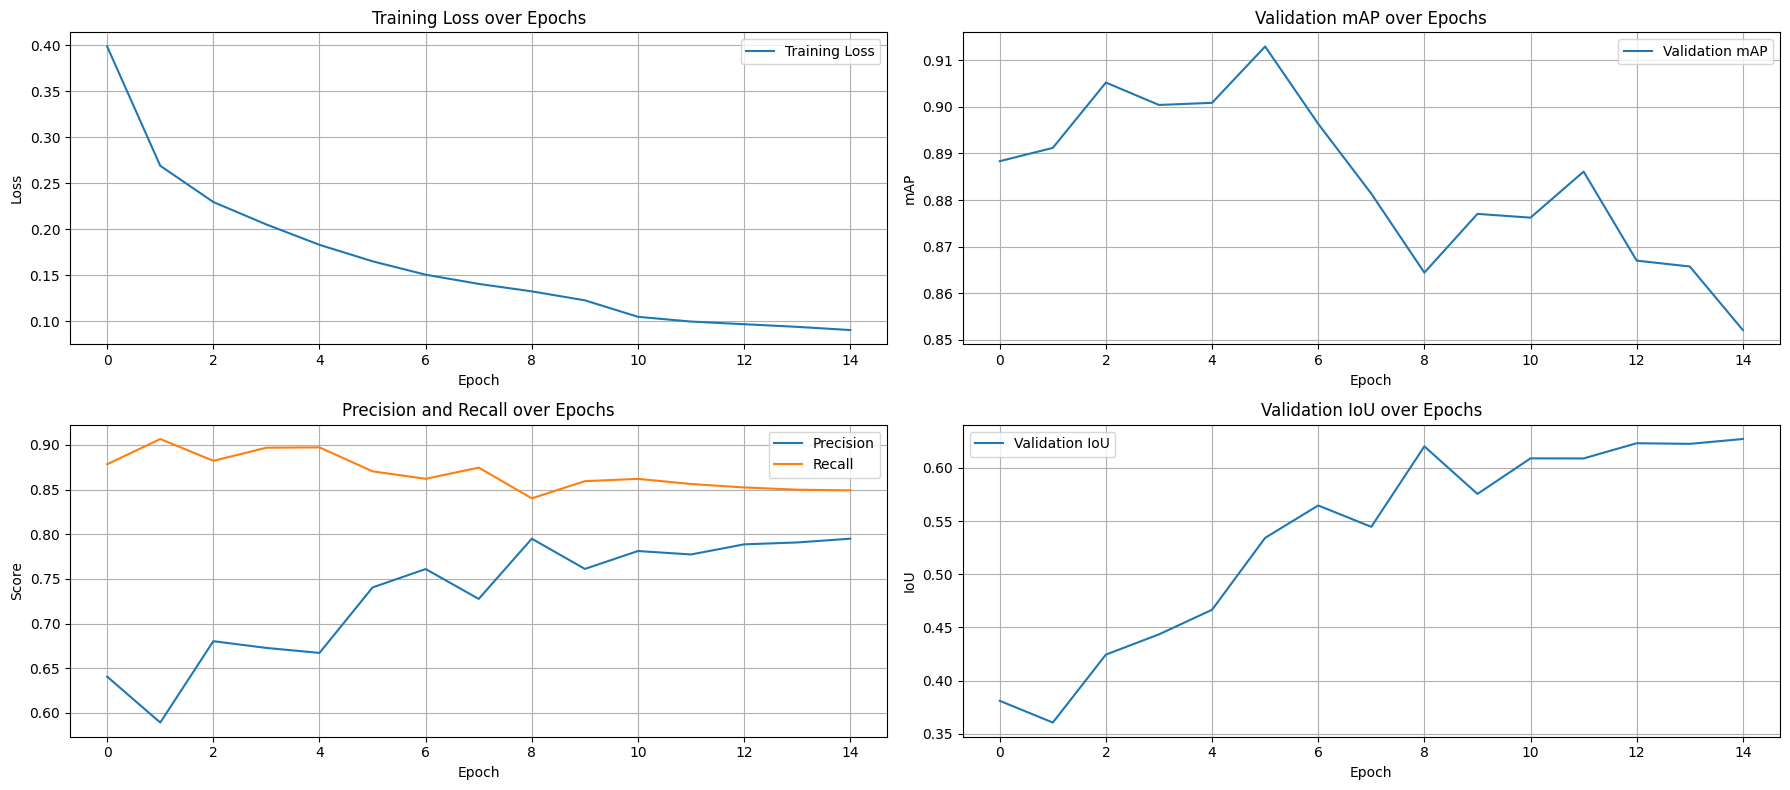

In [18]:
# Load history from checkpoint
plot_training_history(history)

In [19]:
# Get best mAP value
best_map = max(history['val_map'])

# Get epoch with best mAP
best_epoch = history['val_map'].index(best_map)

# Print best results
print(f"Best mAP: {best_map:.4f} at epoch {best_epoch}")
print(f"Corresponding Precision: {history['val_precision'][best_epoch]:.4f}")
print(f"Corresponding Recall: {history['val_recall'][best_epoch]:.4f}")

Best mAP: 0.9130 at epoch 5
Corresponding Precision: 0.7405
Corresponding Recall: 0.8705


In [20]:
# VOC_CLASSES_inverted
VOC_CLASSES_inverted = {v: k for k, v in VOC_CLASSES_ReIndex.items()}
print(VOC_CLASSES_inverted)

{1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}


### visualize_predictions

In [21]:
def visualize_predictions(image, boxes, labels, scores, classes, save_path="predictions_img"):
        
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(18, 12))

    img = image.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    #img = ((img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)
    
    ax.imshow(img)

    classes_inverted = {v: k for k, v in classes.items()}
    
    # Draw each box
    for box, label, score in zip(boxes, labels, scores):
        # Convert box coordinates to integers
        box = box.numpy().astype(np.int32)
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        # Add label and score
        class_name = classes_inverted.get(label.item(), "Unknown") # classes start in 1, do not substract???
        ax.text(
            box[0],
            box[1] - 5,
            f'{class_name}: {score:.2f}',
            bbox=dict(facecolor='red', alpha=0.5),
            color='white'
        )
    
    # Remove axes
    plt.axis('off')
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
    else:
        plt.show()


## Export model to ONNX

In [73]:
def export_model_to_onnx(model, sample_input, output_path):
    """
    Args:
    - model: The trained Faster R-CNN model
    - sample_input: A sample input tensor to trace the model
    - output_path: Path to save the ONNX model
    """
    model.eval()  # Set the model to evaluation mode
    
    # Create a dummy input tensor
    x = sample_input.unsqueeze(0)  # Add batch dimension
    
    # Export the model
    torch.onnx.export(
        model,               # model being run
        x,                   # model input (or a tuple for multiple inputs)
        output_path,         # where to save the model
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=12,    # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=['input'],   # the model's input names
        output_names=['boxes', 'labels', 'scores'],  # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},  # variable length axes
            'boxes': {0: 'num_detections'},
            'labels': {0: 'num_detections'},
            'scores': {0: 'num_detections'}
        }
    )
    
    print(f"Model exported to {output_path}")

In [74]:
# Get a sample input for ONNX export
image_path = 'img.jpg'
image_raw = Image.open(image_path).convert('RGB')

transform.normalize = True
sample_input, _ = transform(image_raw, None)

sample_input = sample_input.to(device)

# sample_images, _ = next(iter(val_loader))
# sample_input = sample_images[0]  # Take the first image from the batch

# Export the model to ONNX
export_model_to_onnx(model, sample_input, 'checkpoints/faster_rcnn_model.onnx')

# Verify ONNX model
def verify_onnx_model(onnx_path):
    try:
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print("ONNX model is valid!")
    except Exception as e:
        print(f"ONNX model validation failed: {e}")

verify_onnx_model('checkpoints/faster_rcnn_model.onnx')

Model exported to checkpoints/faster_rcnn_model.onnx
ONNX model is valid!


In [75]:
def onnx_inference(onnx_path, input_image, confidence_threshold=0.7):

    # Create an ONNX Runtime inference session
    ort_session = ort.InferenceSession(onnx_path)
    
    # Prepare input (add batch dimension if needed)
    input_tensor = input_image.unsqueeze(0).numpy()
    
    # Run inference
    ort_inputs = {ort_session.get_inputs()[0].name: input_tensor}
    ort_outs = ort_session.run(None, ort_inputs)
    
    # ONNX Runtime returns outputs in the order they were specified during export
    boxes, labels, scores = ort_outs
    
    # Convert to tensors and apply confidence threshold
    boxes = torch.from_numpy(boxes)
    labels = torch.from_numpy(labels)
    scores = torch.from_numpy(scores)
    
    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    return boxes, labels, scores


# Perform ONNX inference
def onnx_predict_image(onnx_path, image, confidence_threshold=0.7):
    # Preprocess the image (same as PyTorch preprocessing)
    transform.normalize = False
    image, _ = transform(image, None)
    
    # Run ONNX inference
    boxes, labels, scores = onnx_inference(onnx_path, image, confidence_threshold)
    
    return image, boxes, labels, scores


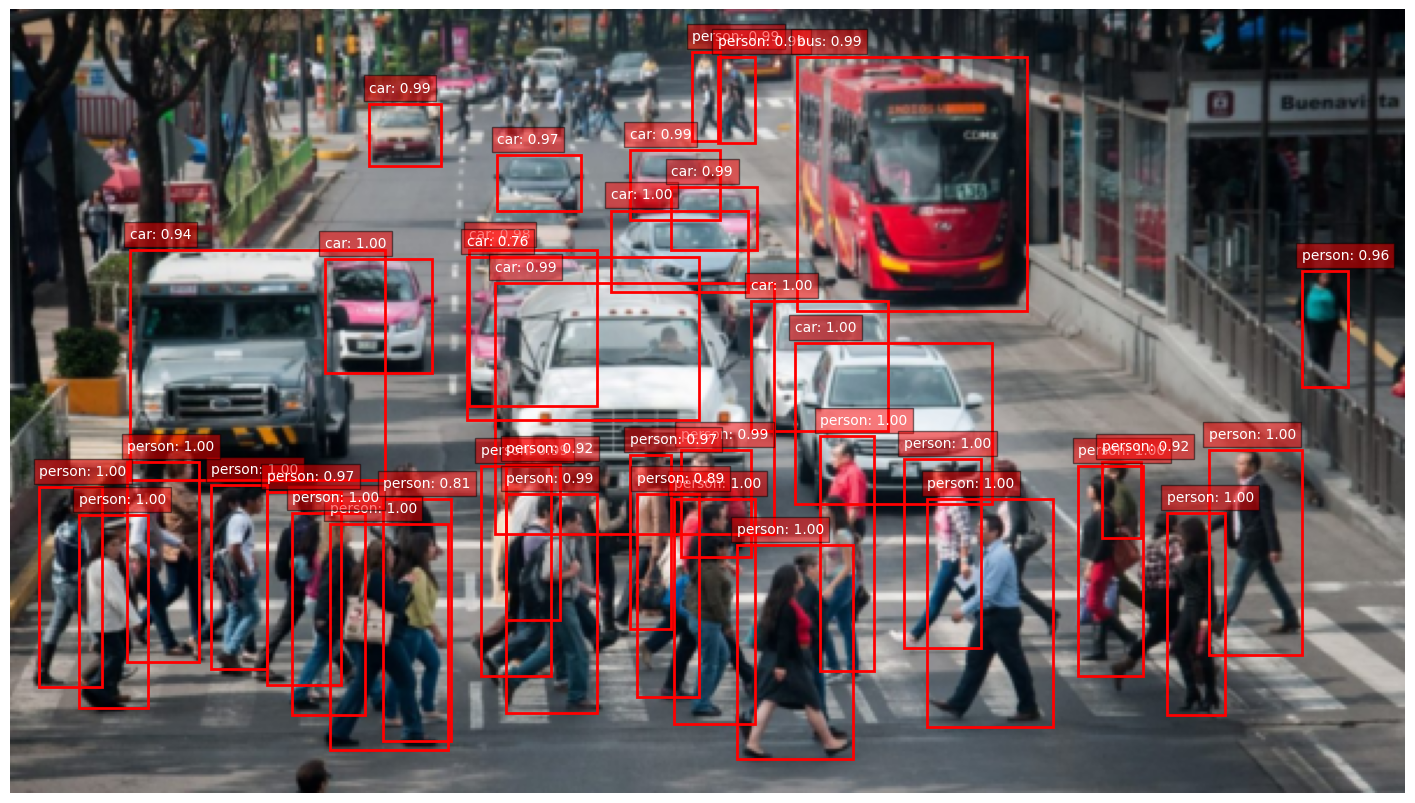

In [76]:
# Example usage
image_path = 'img.jpg'
image_raw = Image.open(image_path).convert('RGB')

# Inference with ONNX model
image, boxes, labels, scores = onnx_predict_image('checkpoints/faster_rcnn_model.onnx', image_raw)
visualize_predictions(image, boxes, labels, scores, VOC_CLASSES_ReIndex)

## Process Video ONNX model

In [26]:
def onnx_predict_image(onnx_path, image, confidence_threshold=0.7):

    # Create an ONNX Runtime inference session
    ort_session = ort.InferenceSession(onnx_path)
    
    # Prepare input (add batch dimension if needed)
    input_tensor = image.unsqueeze(0).numpy()
    
    # Run inference
    ort_inputs = {ort_session.get_inputs()[0].name: input_tensor}
    ort_outs = ort_session.run(None, ort_inputs)
    
    # ONNX Runtime returns outputs in the order they were specified during export
    boxes, labels, scores = ort_outs
    
    # Convert to tensors and apply confidence threshold
    boxes = torch.from_numpy(boxes)
    labels = torch.from_numpy(labels)
    scores = torch.from_numpy(scores)
    
    # Filter by confidence
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    return boxes, labels, scores

def process_video(onnx_model_path, video_path, output_path, class_names, device, 
                 confidence_threshold=0.8, fps=30):
    """
    Process video file and save annotated video using ONNX model
    """
    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return
        
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    out = cv2.VideoWriter(output_path, fourcc, fps, (600, 400)) #resize video output

    # Counter to know how many frames you have read
    frame_count = 0

    # Number of frames to skip
    frame_skip = 30  # Process only every 30 frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break
        
        if frame_count % frame_skip == 0:
            
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Convert to PIL Image
            image = Image.fromarray(frame_rgb)
    
            # Preprocess image
            transform.normalize = False
            image, _ = transform(image, None)

            frame = cv2.resize(frame, (image.shape[2], image.shape[1]))
    
            # Get predictions using ONNX model
            boxes, labels, scores = onnx_predict_image(onnx_model_path, image, confidence_threshold)
            
            # Draw predictions on frame
            for box, label, score in zip(boxes, labels, scores):
                box = box.numpy().astype(np.int32)
                class_name = VOC_CLASSES_inverted.get(label.item(), "Unknown")
                
                # Draw box
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                
                # Add label
                label_text = f'{class_name}: {score:.2f}'
                cv2.putText(frame, label_text, (box[0], box[1] - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
            # Display the processed frame
            cv2.imshow('Video', frame)
            
            # Write frame
            out.write(frame)
    
            # Exit on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        frame_count += 1

    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [27]:
# process_video(
#     onnx_model_path='faster_rcnn_model.onnx', 
#     #video_path=0,             # webCam
#     video_path='input.mp4', 
#     output_path='output.mp4', 
#     class_names=VOC_CLASSES_ReIndex, 
#     device=device
# )

## OpenCV - ONNX

In [90]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [88]:
import torch
from PIL import Image
import torchvision.transforms as T



def export_model_to_onnx(model, sample_input, output_path):
    model.eval()  # Set the model to evaluation mode

    # Add batch dimension to the sample input
    x = sample_input.unsqueeze(0)  # Shape: [1, C, H, W]

    # Export the model to ONNX
    torch.onnx.export(
        model,                    # Model being exported
        x,                        # Model input
        output_path,              # Output file path
        export_params=True,       # Store trained weights inside the model
        opset_version=12,         # ONNX version
        do_constant_folding=True, # Constant folding optimization
        input_names=['input'],    # Input tensor name
        output_names=['boxes', 'labels', 'scores'],  # Output tensor names
        dynamic_axes={
            'input': {0: 'batch_size', 2: 'height', 3: 'width'},  # Dynamic spatial dimensions
            'boxes': {0: 'num_detections'},
            'labels': {0: 'num_detections'},
            'scores': {0: 'num_detections'}
        }
    )
    print(f"Model exported to {output_path}")

# Load and preprocess the sample input image
image_path = 'img.jpg'
image_raw = Image.open(image_path).convert('RGB')

# Define preprocessing pipeline (resize and normalize)
transform = T.Compose([
    T.Resize((400, 600)),  # Ensure this matches the training setup
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust if necessary
])

sample_input = transform(image_raw).to('cuda' if torch.cuda.is_available() else 'cpu')

# Export the model to ONNX
output_path = 'checkpoints/faster_rcnn_model.onnx'
export_model_to_onnx(model, sample_input, output_path)


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 0 has a total capacity of 1.95 GiB of which 3.94 MiB is free. Process 49207 has 770.12 MiB memory in use. Including non-PyTorch memory, this process has 1.19 GiB memory in use. Of the allocated memory 1.10 GiB is allocated by PyTorch, and 54.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [77]:


export_model_to_onnx(model, sample_input, 'faster_rcnn_model_2.onnx')

Model exported successfully to faster_rcnn_model_2.onnx


Model exported successfully to faster_rcnn_model_2.onnx


In [85]:
import onnx

def validate_onnx_model(model_path):
    try:
        # Load the ONNX model
        model = onnx.load(model_path)
        
        # Check the model
        onnx.checker.check_model(model)
        
        print("Model is valid!")
        return True
    except Exception as e:
        print(f"Model validation failed: {e}")
        return False

# Validate the exported model
validate_onnx_model('faster_rcnn_model_2.onnx')

Model is valid!


True

In [86]:
net = cv2.dnn.readNetFromONNX('faster_rcnn_model_2.onnx')

[ERROR:0@2983.730] global onnx_importer.cpp:1035 handleNode DNN/ONNX: ERROR during processing node with 2 inputs and 1 outputs: [Concat]:(onnx_node!/transform/Concat_1) from domain='ai.onnx'


error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1057: error: (-2:Unspecified error) in function 'handleNode'
> Node [Concat@ai.onnx]:(onnx_node!/transform/Concat_1) parse error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/layers/concat_layer.cpp:104: error: (-215:Assertion failed) curShape.size() == outputs[0].size() in function 'getMemoryShapes'
> 

In [31]:
import cv2
import numpy as np

# Load the ONNX model
net = cv2.dnn.readNetFromONNX('checkpoints/faster_rcnn_model.onnx')

# Optional: Set backend and target (e.g., CUDA for GPU inference)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

def preprocess_image(image, input_size=(600, 400)):
    """
    Preprocess image for model input
    
    Args:
    - image: Input image
    - input_size: Resize dimensions
    
    Returns:
    - Preprocessed blob for network input
    """
    # Resize image
    resized = cv2.resize(image, input_size)
    
    # Convert to blob (normalized input)
    blob = cv2.dnn.blobFromImage(
        resized, 
        scalefactor=1/255.0, 
        size=input_size, 
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        swapRB=True,  # Convert BGR to RGB
        crop=False
    )
    
    return blob

def perform_inference(net, blob):
    """
    Perform inference with the ONNX model
    
    Args:
    - net: Loaded OpenCV DNN network
    - blob: Preprocessed input image blob
    
    Returns:
    - Detected boxes, labels, and scores
    """
    # Set input blob
    net.setInput(blob)
    
    # Forward pass
    output_names = ['boxes', 'labels', 'scores']
    outs = net.forward(output_names)
    
    # Extract outputs
    boxes, labels, scores = outs
    
    return boxes, labels, scores

def visualize_detections(image, boxes, labels, scores, class_names, conf_threshold=0.7):
    """
    Visualize detected objects on the image
    
    Args:
    - image: Original input image
    - boxes: Detection bounding boxes
    - labels: Class labels
    - scores: Confidence scores
    - class_names: Mapping of label indices to class names
    - conf_threshold: Minimum confidence to display
    """
    for i in range(len(scores)):
        if scores[i] >= conf_threshold:
            # Extract box coordinates
            box = boxes[i]
            x1, y1, x2, y2 = map(int, box)
            
            # Get class label
            label_idx = int(labels[i])
            class_name = class_names.get(label_idx, 'Unknown')
            
            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Put label and score
            label_text = f'{class_name}: {scores[i]:.2f}'
            cv2.putText(image, label_text, (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

# Example usage
def main():
    # Load image
    image = cv2.imread('img.jpg')
    
    # Preprocess
    blob = preprocess_image(image)
    
    # Inference
    boxes, labels, scores = perform_inference(net, blob)
    
    # Visualize
    class_names = {1: 'bicycle', 2: 'bus', 3: 'car', 4: 'motorbike', 5: 'person'}
    result_image = visualize_detections(image, boxes[0], labels[0], scores[0], class_names)
    
    # Display and save
    cv2.imshow('Detections', result_image)
    cv2.waitKey(0)
    cv2.imwrite('detections.jpg', result_image)

if __name__ == '__main__':
    main()

[ERROR:0@476.046] global onnx_importer.cpp:1035 handleNode DNN/ONNX: ERROR during processing node with 2 inputs and 1 outputs: [Concat]:(onnx_node!/transform/Concat_1) from domain='ai.onnx'


error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1057: error: (-2:Unspecified error) in function 'handleNode'
> Node [Concat@ai.onnx]:(onnx_node!/transform/Concat_1) parse error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/layers/concat_layer.cpp:104: error: (-215:Assertion failed) curShape.size() == outputs[0].size() in function 'getMemoryShapes'
> 

In [ ]:
def export_model_to_onnx(model, sample_input, output_path='faster_rcnn_model.onnx'):
    model.eval()
    x = sample_input.unsqueeze(0)
    
    torch.onnx.export(
        model,               
        x,                   
        output_path,         
        export_params=True,  
        opset_version=12,    # Try different opset versions
        do_constant_folding=True,
        input_names=['input'],   
        output_names=['boxes', 'labels', 'scores'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'boxes': {0: 'num_detections'},
            'labels': {0: 'num_detections'},
            'scores': {0: 'num_detections'}
        },
        # Additional export options
        keep_initializers_as_inputs=False
    )

In [ ]:
import onnx

# Validate ONNX model
model = onnx.load('faster_rcnn_model.onnx')
onnx.checker.check_model(model)
print("Model is valid")

In [ ]:
def alternative_visualize(image, boxes, labels, scores, class_names, conf_threshold=0.5):
    for i in range(len(scores)):
        if scores[i] > conf_threshold:
            box = boxes[i]
            label = labels[i]
            score = scores[i]
            
            # Ensure box coordinates are integers
            x1, y1, x2, y2 = map(int, [box[0], box[1], box[2], box[3]])
            
            class_name = class_names.get(label, 'Unknown')
            
            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Put text
            label_text = f'{class_name}: {score:.2f}'
            cv2.putText(image, label_text, (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2

# Load ONNX model with ONNX Runtime
session = ort.InferenceSession('faster_rcnn_model.onnx')

def preprocess_image(image, input_size=(600, 400)):
    # Resize
    resized = cv2.resize(image, input_size)
    
    # Normalize
    normalized = resized.astype(np.float32) / 255.0
    
    # Transpose to match ONNX model input
    input_tensor = normalized.transpose(2, 0, 1)
    input_tensor = input_tensor[np.newaxis, :, :, :]
    
    return input_tensor

def onnx_inference(image):
    # Preprocess
    input_tensor = preprocess_image(image)
    
    # Prepare input
    input_name = session.get_inputs()[0].name
    
    # Run inference
    outputs = session.run(None, {input_name: input_tensor})
    
    # Outputs typically: [boxes, labels, scores]
    boxes, labels, scores = outputs
    
    return boxes[0], labels[0], scores[0]

def visualize_detections(image, boxes, labels, scores, 
                          class_names, conf_threshold=0.5):
    for box, label, score in zip(boxes, labels, scores):
        if score > conf_threshold:
            # Convert box coordinates
            x1, y1, x2, y2 = map(int, box)
            
            # Get class name
            class_name = class_names.get(label, 'Unknown')
            
            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Put text
            label_text = f'{class_name}: {score:.2f}'
            cv2.putText(image, label_text, (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Example usage
def main():
    # Load image
    image = cv2.imread('img.jpg')
    
    # Class names mapping
    class_names = {
        1: 'bicycle', 
        2: 'bus', 
        3: 'car', 
        4: 'motorbike', 
        5: 'person'
    }
    
    # Inference
    boxes, labels, scores = onnx_inference(image)
    
    # Visualize
    result = visualize_detections(image, boxes, labels, scores, class_names)
    
    # Display
    cv2.imshow('Detections', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()